# Virtual Flow Meter using critical flow data at production choke
### Data and methodologies mentioned in reference below are reproduced here.
##### Reference: Barjouei, H.S., Ghorbani, H., Mohamadian, N. et al. Prediction performance advantages of deep machine learning algorithms for two-phase flow rates through wellhead chokes. J Petrol Explor Prod Technol 11, 1233–1261 (2021). https://link.springer.com/article/10.1007/s13202-021-01087-4 [Accessed 3 Jun 2021]


### Load Python Libraries

In [2]:
# Data storage, exploration
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# The following three lines allow multiple and non-truncated outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)

# Import Data & Preliminary Data Exploration
1. How many data records? 
2. How many variables / features or columns in each data record?
3. Peek at the first five records and the last five records

In [4]:
# Import Data
vfm = pd.read_csv('/content/drive/MyDrive/ALCE-22/SorushDatasetChokeFlow.csv')
vfm.columns = ['SampleID', 'Well', 'D64', 'Pwh', 'γo', 'GLR', 'QL']

In [5]:
vfm.info()
vfm.head()
vfm.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7245 entries, 0 to 7244
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SampleID  7245 non-null   int64  
 1   Well      7245 non-null   object 
 2   D64       7245 non-null   float64
 3   Pwh       7245 non-null   float64
 4   γo        7245 non-null   float64
 5   GLR       7245 non-null   int64  
 6   QL        7245 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 396.3+ KB


,SampleID,Well,D64,Pwh,γo,GLR,QL
0,1,SR-17,71.424,175.930730,1.063251,152,10853.69614
1,2,SR-17,71.424,176.075768,1.063251,152,11019.74712
2,3,SR-17,71.424,174.915466,1.063251,152,11125.41593
3,4,SR-17,71.424,175.785692,1.063251,152,11110.32038
4,5,SR-17,71.424,175.205542,1.063251,152,11095.22484


,SampleID,Well,D64,Pwh,γo,GLR,QL
7240,7241,SR-26,41.216,440.624533,1.023322,118,6898.663608
7241,7242,SR-26,41.216,441.494759,1.023322,118,6913.759152
7242,7243,SR-26,41.216,442.655060,1.023322,118,6913.759152
7243,7244,SR-26,41.216,438.739042,1.023322,118,6913.759152
7244,7245,SR-26,41.216,439.754306,1.023322,118,6913.759152


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

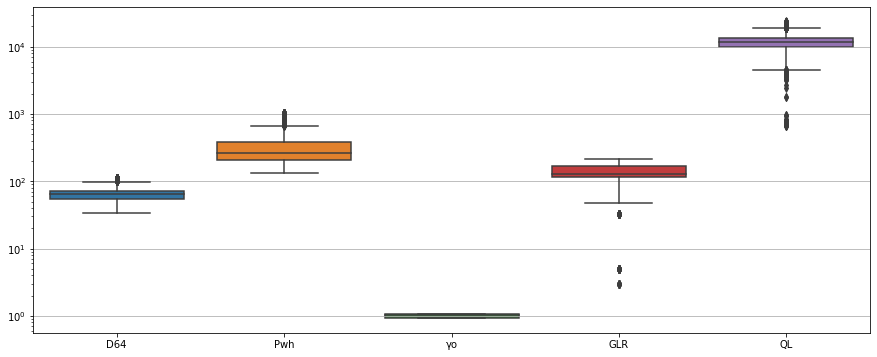

In [9]:
# Plot Statistics
plt.figure(figsize=(15,6));
plt.yscale("log");
plt.grid('y');
#_ = plt.xticks(rotation='vertical');
sns.boxplot(data=vfm.drop(columns=['SampleID', 'Well']))

### Boxplot Visualization
1. In the visualization above, why some boxes are very tall (long color bars).
2. Which variable has the smallest distribution?
3. Which variable is widely distributed?
4. What does it mean when one whisker is longer than the other?

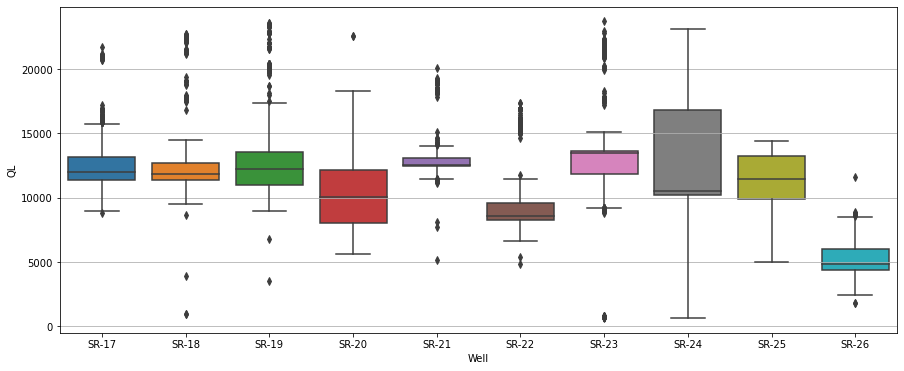

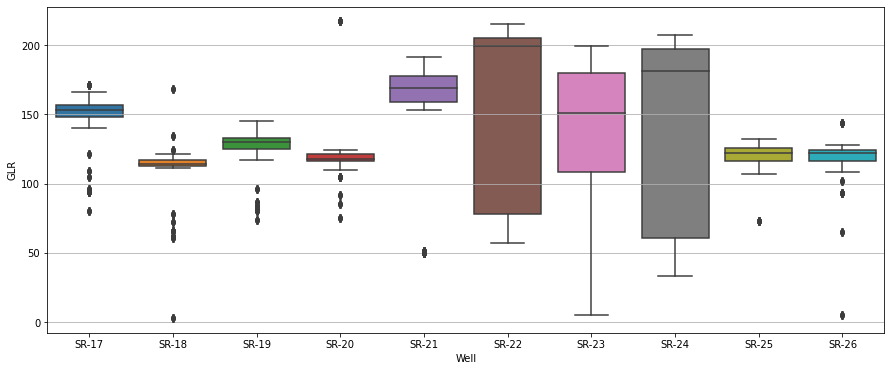

In [12]:
plt.figure(figsize=(15,6));
plt.grid('y');
sns.boxplot(data=vfm, x="Well", y="QL");
plt.figure(figsize=(15,6));
plt.grid('y');
sns.boxplot(data=vfm, x="Well", y="GLR");

### Histograms
Help visualize how measurements are distributed.
Wouldn't we like them to be normally distributed?!?

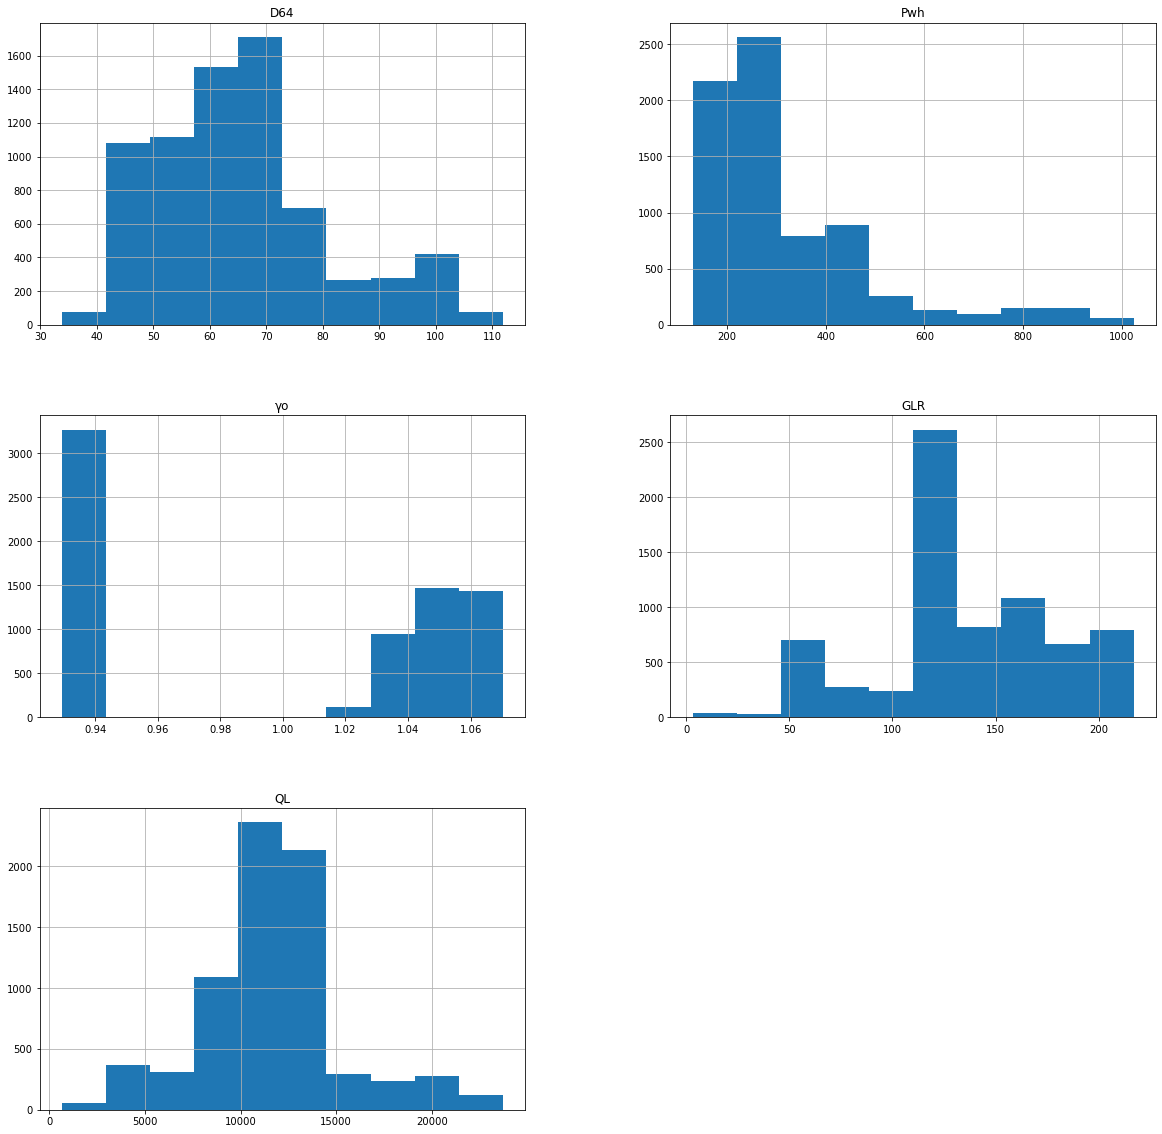

In [13]:
vfm.drop(columns=['SampleID']).hist(figsize=(20, 20));

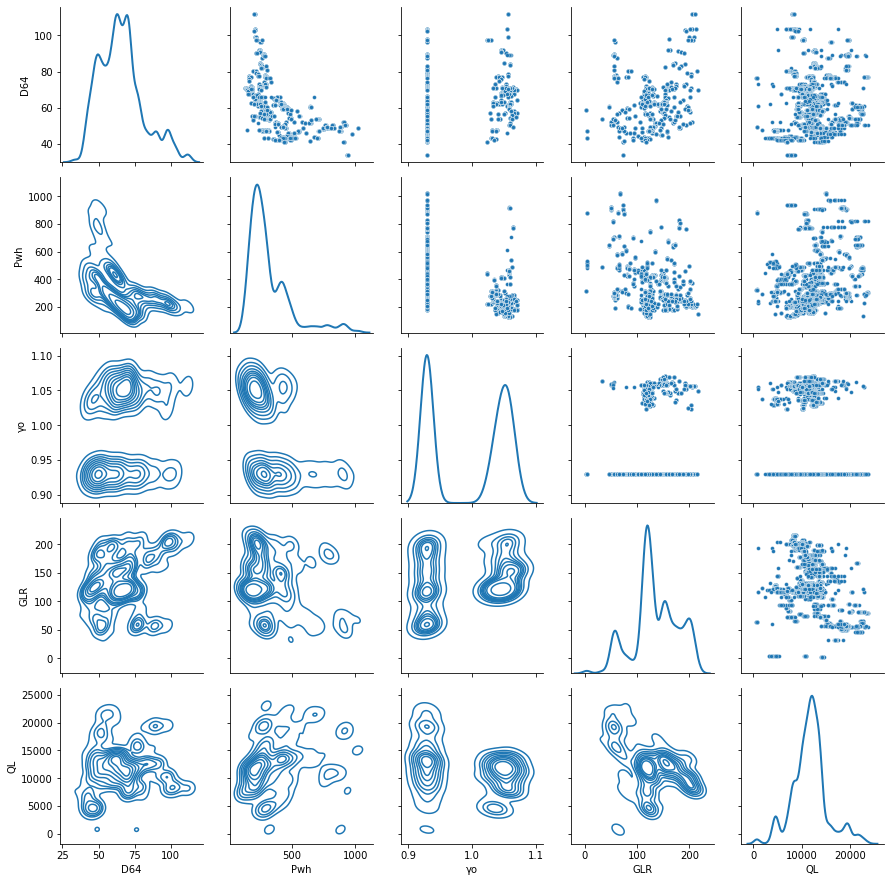

In [15]:
plot_vars = ['D64', 'Pwh', 'γo', 'GLR', 'QL']
# Define a function to plot histogram and scatterplot for the specified variables/columns of provided dataframe 
def plotPairgrid(df, plot_vars):
    g = sns.PairGrid(data=df, vars=plot_vars, diag_sharey=False);
    g.map_upper(sns.scatterplot, s=15);
    g.map_lower(sns.kdeplot);
    g.map_diag(sns.kdeplot, lw=2);

plotPairgrid(vfm, plot_vars);

### Correlations between Variables
Let's find out if any of the two variables are correlated by calculating correlation coefficients between them. 
1. Positive value (positive correlation) means one increases with another in the dataset; and 
2. Negative value (negative correlation) means one decreases while another increases and vice versa. 
3. Magnitude of the correlation coefficient indicates strength of the correlation.

There are multiple ways to perform this task. We will calculate Pearson and Spearman coefficeints.
#### Pearson Correlation Coefficient
Pearson correlation assumes that the data we are comparing is normally distributed. When that assumption is not true, the correlation value is reflecting the true association.

#### Spearman Rank Correlation
Spearman correlation does not assume that data is from a specific distribution, so it is a non-parametric correlation measure. Spearman correlation is also known as Spearman’s rank correlation as it computes correlation coefficient on rank values of the data.

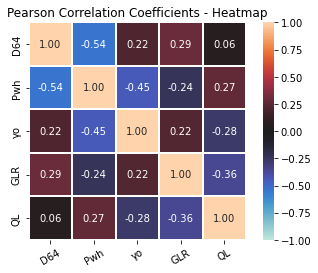

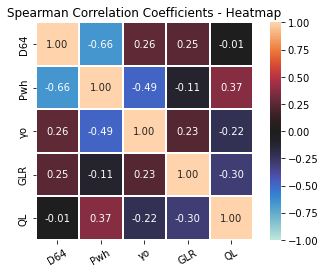

In [21]:
def plot_corrcoeff(method):
    dfCorr = vfm[plot_vars].corr(method=method)
    g1 = sns.heatmap(dfCorr, center=0.0, linewidths=0.1, square=True, annot=True, vmin=-1, vmax=1., fmt='1.2f')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30);
    g1.set_title(method.capitalize() + ' Correlation Coefficients - Heatmap')
    plt.show()

# Pearson Correlation Coefficient
plot_corrcoeff(method='pearson')

# Spearman Rank Correlation
plot_corrcoeff(method='spearman')

Spearman’s correlation coefficients shown above reveal that the input variables,
* GLR and γo are inversely related to QL, 
* Pwh display +ve correlation with QL and -ve correlation with D64.
* D64 shows the weakest correlation with QL of the four input variables evaluated, i.e., the flowrate is insensitive to choke size. The prevailing flow through the wellhead chokes of the Sorush oil field conforms to a critical flow regime

# Data Exploration
### Missing Data at Macro Level
Are there any null (NaN) measurements for numeric data columns?

In [22]:
# Q1. How many nulls are there?
vfm.isnull().sum()

# Q2. How many values are zero or -ve
(vfm[plot_vars] <= 0.0).sum()

SampleID    0
Well        0
D64         0
Pwh         0
γo          0
GLR         0
QL          0
dtype: int64

D64    0
Pwh    0
γo     0
GLR    0
QL     0
dtype: int64

### Prepare features and target data arrays 
1. Convert from data-frame column(s) to numpy-arrays
2. Normalize all the features (why?)
3. Separate the data in training and test sets

In [36]:
# Separate targets from inputs
X = vfm[plot_vars].drop(columns='QL').to_numpy()
y = vfm['QL'].to_numpy()
X.shape, y.shape

((7245, 4), (7245,))

In [37]:
# Do we need to normalize X - input features?
X[:5]
# Normalize all the samples between [-1, +1]
X = (X - X.min(axis=0))/(X.max(axis=0) - X.min(axis=0))*2 - 1
X[:5]

array([[ 71.424     , 175.9307301 ,   1.06325088, 152.        ],
       [ 71.424     , 176.0757678 ,   1.06325088, 152.        ],
       [ 71.424     , 174.9154662 ,   1.06325088, 152.        ],
       [ 71.424     , 175.7856924 ,   1.06325088, 152.        ],
       [ 71.424     , 175.2055416 ,   1.06325088, 152.        ]])

array([[-0.03606557, -0.89832711,  0.89974937,  0.39252336],
       [-0.03606557, -0.89800227,  0.89974937,  0.39252336],
       [-0.03606557, -0.90060094,  0.89974937,  0.39252336],
       [-0.03606557, -0.89865194,  0.89974937,  0.39252336],
       [-0.03606557, -0.89995127,  0.89974937,  0.39252336]])

In [41]:
## Sub-divide datatest into training and testing: 80 - 20% split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_spBlit(
    X, y, 
    test_size=0.2, random_state=1002)

In [ ]:
# Set up a callable function for relevant metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def calc_predMetrics(y_true, y_pred, method_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'method':method_name, 'rmse':rmse, 'MAE': mae, 'MAPE':mape, 'R2':r2}

# Initialize list to store calculated metric values for each model
pred_perf_metric = []

### Support Vector Regression (SVR)
In this study, the RBF kernel is used with the SVR algorithm to predict two-phase flow rate (Ql) through a wellhead choke.

In [43]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel="rbf", C=100000, gamma=0.05, epsilon=0.1)
y_pred_svr = svr_rbf.fit(X_train, y_train).predict(X_test)

pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_svr, method_name="SVR"))

### Decision Tree (DT)
In this study, a the scikit learn (sklearn) decision tree module is coded applying the “gini” criterion to establish feature importance and the “best” splitter is applied to decide which feature and the value of the threshold to apply in making each split.

In [45]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=100, splitter='best', 
                           criterion='squared_error', random_state=1002)
y_pred_dt = dt.fit(X_train, y_train).predict(X_test)

pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_dt, method_name="DT"))

### RandomForest (RF)


In [46]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, max_depth=1000, 
                           criterion='squared_error', random_state=0)
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)

pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_rf, method_name="Random Forest" ))

### ExtraTrees (ET)

In [48]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=1000, max_depth=1000, 
                           criterion='squared_error', random_state=0)
y_pred_et = et.fit(X_train, y_train).predict(X_test)

pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_et, method_name="Extra Trees"))

### eXtreme Gradient Boosting (XGB)

In [50]:
import xgboost as xgb
xgbm = xgb.XGBRegressor()
y_pred_xgb = xgbm.fit(X_train, y_train).predict(X_test)

pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_xgb, method_name="XGBoost"))

### Artificial Neural Network (ANN) using Keras

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', min_delta=0.001, patience=25)

# build model
nn = Sequential()
nn.add(Dense(50, input_dim=4, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(50, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(50, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(50, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(50, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(50, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(1, activation='selu'))

# compile model
nn.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.01))
# fit model
nn.fit(X_train, y_train, epochs=100, verbose=0)

# evaluate the model
y_pred_nn = nn.predict(X_test)

pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_nn, method_name="ANN"))

### Plot relative performance of methods

Text(0.5, 1.0, 'RMSE, bbls/day')

[Text(1, 0, '2724.8'),
 Text(1, 0, '839.6'),
 Text(1, 0, '839.6'),
 Text(1, 0, '736.9'),
 Text(1, 0, '727.3'),
 Text(1, 0, '714.7'),
 Text(1, 0, '714.7'),
 Text(1, 0, '1297.8')]

(0.0, 4000.0)

Text(0.5, 1.0, 'MAPE, %')

[Text(1, 0, '0.407'),
 Text(1, 0, '0.019'),
 Text(1, 0, '0.019'),
 Text(1, 0, '0.018'),
 Text(1, 0, '0.020'),
 Text(1, 0, '0.017'),
 Text(1, 0, '0.017'),
 Text(1, 0, '0.092')]

(0.0, 0.6)

Text(0.5, 1.0, 'R2 Coefficient')

[Text(0, 0, '0.445'),
 Text(0, 0, '0.947'),
 Text(0, 0, '0.947'),
 Text(0, 0, '0.959'),
 Text(0, 0, '0.960'),
 Text(0, 0, '0.962'),
 Text(0, 0, '0.962'),
 Text(0, 0, '0.874')]

(0.0, 1.2)

Text(0.5, 0.98, 'ML Methods Comparison')

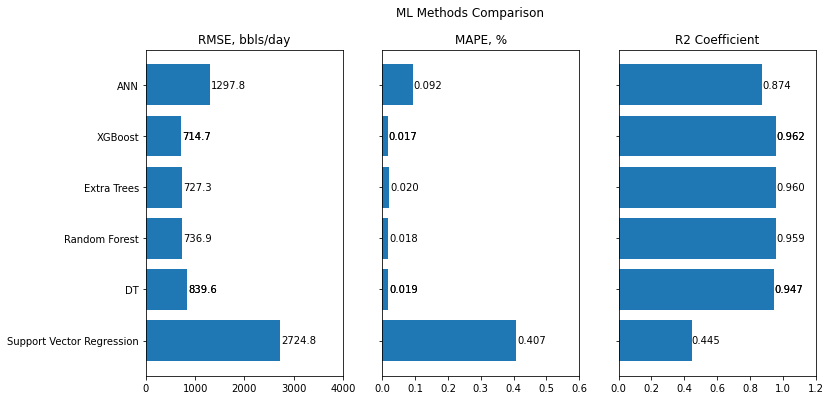

In [53]:
# Convert predicted performance metric list of dictionaries into a dataframe 
plotDf = pd.DataFrame(pred_perf_metric)

fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
# Plot # 1 - Root Mean Square Error
rect1 = axs[0].barh(plotDf.method, plotDf.rmse);
axs[0].set_title('RMSE, bbls/day');
axs[0].bar_label(rect1, padding=1, fmt='%.1f');
axs[0].set_xlim(0., 4000.);

# Plot # 2 - Mean Absolute Percentage Error (MAPE)
rect2 = axs[1].barh(plotDf.method, plotDf.MAPE);
axs[1].set_title('MAPE, %');
axs[1].bar_label(rect2, padding=1, fmt='%.3f');
axs[1].set_xlim(0., 0.6);

# Plot # 3 - R2 Coefficient of Determination
rect3 = axs[2].barh(plotDf.method, plotDf.R2);
axs[2].set_title('R2 Coefficient');
axs[2].bar_label(rect3, padding=0, fmt='%.3f');
axs[2].set_xlim(0., 1.2);

fig.suptitle('ML Methods Comparison')